In [61]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from scipy import integrate


In [42]:
!python --version

Python 3.6.9


In [2]:
all_data = pd.read_excel("/content/Данные (1).xlsx", skiprows=3)

In [3]:
#sheetname - здесь сможем менять названание файла

second_list = pd.read_excel("/content/Данные (1).xlsx", sheet_name="1_2", skiprows=3)
all_data = second_list

In [4]:
all_data.head()

,Наименование организации,2015-01-01 00:00:00,2015-02-01 00:00:00,2015-03-01 00:00:00,2015-04-01 00:00:00,2015-05-01 00:00:00,2015-06-01 00:00:00,2015-07-01 00:00:00,2015-08-01 00:00:00,2015-09-01 00:00:00,2015-10-01 00:00:00,2015-11-01 00:00:00,2015-12-01 00:00:00,2016-01-01 00:00:00,2016-02-01 00:00:00,2016-03-01 00:00:00,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,2016-08-01 00:00:00,2016-09-01 00:00:00,2016-10-01 00:00:00,2016-11-01 00:00:00,2016-12-01 00:00:00,2017-01-01 00:00:00,2017-02-01 00:00:00,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00
0,Х1,15.45,15.45,15.99,16.1,16.21,15.77,16.15,14.74,15.83,17.23,17.33,16.34,17.17,18.41,18.41,19,19.32,26.05,23.02,21.04,22.37,20.58,20.57,22.02,23.38,30.555,36.664,28.918,27.68,28.371,27.55,32.982,31.358,32.339,37.87,51.269,50.822,54.001,54.039,55.829,55.438,56.783,56.159,56.226,55.593,55.361,55.068,55.309,53.492,54.741,54.568,53.887,56.569,61.051,61.813,59.786,66.61,64.129,68.099,66.077,67.112,66.181,68.626,62.673,62.765,64.559,81.599,71.384
1,Х2,17.66,24.15,22.13,20.17,23.49,24.16,23.91,21.86,21.29,23.73,21.11,27.8,24.25,26.59,26.28,24.09,29.33,29.15,29.79,30.12,29.16,30.04,30.82,31.67,32.04,30.454,30.954,31.365,31.226,32.312,32.056,31.407,31.596,32.135,32.242,32.609,33.492,33.705,32.277,29.336,28.176,29.8,30.003,30.032,31.834,32.69,34.293,35.644,40.696,43.994,43.618,43.274,40.115,39.269,40.836,40.522,41.539,40.328,41.633,42.28,42.946,42.762,43.586,42.883,41.793,40.712,40.72,41.573
2,Х3,27.75,32.65,29.24,29.24,23.16,21.89,22.37,23.79,24.97,24.17,24.34,23.32,27.85,31.93,32.34,34.78,33.91,28.91,30.21,29.15,28.54,27.81,29.99,31.51,34.22,30.351,32.887,30.847,29.629,28.112,27.874,27.222,25.371,24.822,25.026,24.871,24.393,27.118,28.144,27.864,27.705,24.573,34.702,30.7,27.238,26.388,26.142,26.505,26.198,29.3,28.385,29.73,30.975,29.705,28.508,28.887,29.476,29.676,30.12,29.597,29.79,31.837,31.91,35.011,35.757,35.43,36.058,37.609
3,Х4,15.83,15.56,16.73,17.31,18.14,18.65,19.5,19.78,19.47,19.23,19.63,19.92,19.43,20.48,19.94,20.14,20.51,20.36,20.23,19.89,18.99,18.58,18.65,18.19,17.77,17.918,17.84,17.372,17.03,16.7,16.46,16.389,15.915,15.543,14.947,14.615,13.956,14.265,14.285,13.776,13.743,13.738,13.487,13.416,13.04,12.468,12.291,12.157,11.699,12.032,12.006,11.92,11.541,11.678,11.345,11.105,10.964,10.673,10.249,10.211,11.246,10.787,10.507,10.543,11.037,11.574,11.04,11.053
4,Х5,16.19,14.34,15.64,16.52,18.29,17.76,17.87,18.15,19.41,18.84,19.94,20.66,21.5,23.94,24.84,27.54,27.6,29.17,32.27,31.93,32.95,35.82,35.05,36.51,35.62,32.809,34.885,38.228,41.358,42.155,45.796,44.951,47.998,46.599,47.196,48.33,50.031,48.163,46.526,50.261,50.337,49.207,68.234,63.059,62.288,63.864,55.838,62.277,67.948,65.774,48.981,49.043,48.494,44.287,41.199,39.794,49.486,44.162,51.801,51.276,50.294,52.835,55.199,40.563,43.341,42.346,37.892,43.558


In [5]:
good_company = all_data.iloc[0:358]

In [6]:
good_company

,Наименование организации,2015-01-01 00:00:00,2015-02-01 00:00:00,2015-03-01 00:00:00,2015-04-01 00:00:00,2015-05-01 00:00:00,2015-06-01 00:00:00,2015-07-01 00:00:00,2015-08-01 00:00:00,2015-09-01 00:00:00,2015-10-01 00:00:00,2015-11-01 00:00:00,2015-12-01 00:00:00,2016-01-01 00:00:00,2016-02-01 00:00:00,2016-03-01 00:00:00,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,2016-08-01 00:00:00,2016-09-01 00:00:00,2016-10-01 00:00:00,2016-11-01 00:00:00,2016-12-01 00:00:00,2017-01-01 00:00:00,2017-02-01 00:00:00,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00
0,Х1,15.45,15.45,15.99,16.1,16.21,15.77,16.15,14.74,15.83,17.23,17.33,16.34,17.17,18.41,18.41,19,19.32,26.05,23.02,21.04,22.37,20.58,20.57,22.02,23.38,30.555,36.664,28.918,27.68,28.371,27.55,32.982,31.358,32.339,37.87,51.269,50.822,54.001,54.039,55.829,55.438,56.783,56.159,56.226,55.593,55.361,55.068,55.309,53.492,54.741,54.568,53.887,56.569,61.051,61.813,59.786,66.61,64.129,68.099,66.077,67.112,66.181,68.626,62.673,62.765,64.559,81.599,71.384
1,Х2,17.66,24.15,22.13,20.17,23.49,24.16,23.91,21.86,21.29,23.73,21.11,27.8,24.25,26.59,26.28,24.09,29.33,29.15,29.79,30.12,29.16,30.04,30.82,31.67,32.04,30.454,30.954,31.365,31.226,32.312,32.056,31.407,31.596,32.135,32.242,32.609,33.492,33.705,32.277,29.336,28.176,29.8,30.003,30.032,31.834,32.69,34.293,35.644,40.696,43.994,43.618,43.274,40.115,39.269,40.836,40.522,41.539,40.328,41.633,42.28,42.946,42.762,43.586,42.883,41.793,40.712,40.72,41.573
2,Х3,27.75,32.65,29.24,29.24,23.16,21.89,22.37,23.79,24.97,24.17,24.34,23.32,27.85,31.93,32.34,34.78,33.91,28.91,30.21,29.15,28.54,27.81,29.99,31.51,34.22,30.351,32.887,30.847,29.629,28.112,27.874,27.222,25.371,24.822,25.026,24.871,24.393,27.118,28.144,27.864,27.705,24.573,34.702,30.7,27.238,26.388,26.142,26.505,26.198,29.3,28.385,29.73,30.975,29.705,28.508,28.887,29.476,29.676,30.12,29.597,29.79,31.837,31.91,35.011,35.757,35.43,36.058,37.609
3,Х4,15.83,15.56,16.73,17.31,18.14,18.65,19.5,19.78,19.47,19.23,19.63,19.92,19.43,20.48,19.94,20.14,20.51,20.36,20.23,19.89,18.99,18.58,18.65,18.19,17.77,17.918,17.84,17.372,17.03,16.7,16.46,16.389,15.915,15.543,14.947,14.615,13.956,14.265,14.285,13.776,13.743,13.738,13.487,13.416,13.04,12.468,12.291,12.157,11.699,12.032,12.006,11.92,11.541,11.678,11.345,11.105,10.964,10.673,10.249,10.211,11.246,10.787,10.507,10.543,11.037,11.574,11.04,11.053
4,Х5,16.19,14.34,15.64,16.52,18.29,17.76,17.87,18.15,19.41,18.84,19.94,20.66,21.5,23.94,24.84,27.54,27.6,29.17,32.27,31.93,32.95,35.82,35.05,36.51,35.62,32.809,34.885,38.228,41.358,42.155,45.796,44.951,47.998,46.599,47.196,48.33,50.031,48.163,46.526,50.261,50.337,49.207,68.234,63.059,62.288,63.864,55.838,62.277,67.948,65.774,48.981,49.043,48.494,44.287,41.199,39.794,49.486,44.162,51.801,51.276,50.294,52.835,55.199,40.563,43.341,42.346,37.892,43.558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,Х354,12.49,12.44,12.55,13.28,13.54,14.05,15.95,15.18,15.18,14.48,14.15,14.12,14.89,14

In [7]:
default_company=all_data.iloc[363:]

In [8]:
default_company_pv=pd.pivot_table(default_company, index=["Наименование организации"], aggfunc=np.sum)

In [9]:
good_company_pv=pd.pivot_table(good_company, index=["Наименование организации"], aggfunc=np.sum)

In [10]:
#удаление 

In [11]:
#prepare data for machine learning

In [12]:
default_company_pv['label']=1

In [13]:
good_company_pv['label']=0

In [14]:
frames = [default_company_pv, good_company_pv]
df = pd.concat(frames)

In [15]:
df_sh = df.sample(n=len(df), random_state=42)

In [16]:
df_sh = df_sh[(df_sh.T != 0).any()]

In [17]:
#remove zeros
default_company = default_company[(default_company.T != 0).any()]
default_company

,Наименование организации,2015-01-01 00:00:00,2015-02-01 00:00:00,2015-03-01 00:00:00,2015-04-01 00:00:00,2015-05-01 00:00:00,2015-06-01 00:00:00,2015-07-01 00:00:00,2015-08-01 00:00:00,2015-09-01 00:00:00,2015-10-01 00:00:00,2015-11-01 00:00:00,2015-12-01 00:00:00,2016-01-01 00:00:00,2016-02-01 00:00:00,2016-03-01 00:00:00,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,2016-08-01 00:00:00,2016-09-01 00:00:00,2016-10-01 00:00:00,2016-11-01 00:00:00,2016-12-01 00:00:00,2017-01-01 00:00:00,2017-02-01 00:00:00,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00
363,Д1.15,14.85,15.59,18.54,17.24,18.85,17.02,20.82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
364,Д2.15,10.56,10.43,12.77,12.6,12.56,13.03,12.52,11.74,10.89,11.65,11.89,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
365,Д3.15,12.66,11.27,10.51,10.49,11.02,10.13,10.25,10.24,10.19,10.15,11.15,10.07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
366,Д4.15,12.74,12.46,12.87,11.98,11.19,11.33,11.08,11.03,11.08,11.21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
367,Д5.15,27.4,26.03,26.3,25.24,23.77,23.75,14.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,Д8.2,58.14,60.28,58.91,53.72,52.33,52.64,52.25,49.67,51.82,47.55,48.46,46.74,47.55,37.88,50.17,46.75,44.66,40.26,43.26,47.92,43.21,49.14,47.45,43.15,63.01,67.208,68.671,54.769,45.316,47.124,40.113,38.063,49.388,45.516,44.337,45.156,63.262,63.027,63.668,59.73,63.731,65.584,64.08,61.237,59.283,59.45,66.759,68.031,66.63,56.216,59.502,60.642,48.888,51.385,48.765,54.08,57.386,62.643,58.412,54.063,51.68,56.187,51.103,48.58,54.25,49.288,52.241,0
634,Д9.2,30.2,33.5,33.97,35.06,34.18,33.16,22.65,25.42,24.95,24.29,24.09,21.5,22.56,20.5,21.85,27.85,27.02,22.35,23.56,24.96,28.14,24.47,26.26,27.5,27.35,21.892,22.463,26.813,22.282,24.711,20.686,19.229,20.064,21.13,17.992,15.307,20.883,16.378,21.851,17.477,17.894,24.385,23.117,23.201,23.184,22.267,23.669,23.294,28.244,26.097,25.167,23.6,24.548,31.199,34.939,34.322,36.236,41.064,36.828,37.485,38.944,37.081,35.757,36.193,33.114,33.759,31.666,0
635,Д10.2,19.24,17.66,19.01,23.77,25.01,24.84,24.89,24.07,22,21.64,25.54,22.46,21.77,24.16,23.99,24.92,27.07,16.28,17.16,26.36,28.52,28.71,27.91,29.28,28.57,28.506,29.139,21.467,29.581,31.491,27.954,27.381,27.353,23.214,26.194,26.005,25.78,53.103,54.95,51.333,49.989,44.718,53.754,54.612,54.199,53.672,50.104,56.287,56.83,53.386,56.691,28.769,29.431,28.856,27.639,30.371,30.223,31.192,31.908,35.606,32.373,43.316,48.535,46.998,51.127,55.873,52.537,0
636,Д11.2,25.67,24.58,25.72,26.05,28.93,26.24,26.17,24.23,20.4,23.55,23.83,2

In [18]:
y_name='label'
X = df_sh[df_sh.columns.difference([y_name])]
y = df_sh[y_name]


In [19]:
X.columns=['X'+str(i) for i in range(len(X.columns))]

In [20]:
for column in X.columns:
  X[column]=pd.to_numeric(X[column])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
def test_train(X, y, ratio=0.2,random_state=100):
		from sklearn.model_selection import train_test_split
		train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=ratio)
		return train_X, test_X, train_y, test_y 

In [22]:
train_X, test_X, train_y, test_y  = train_test_split(X, y, test_size=0.2)

In [23]:
model = xgb.XGBClassifier()
model2 = RandomForestClassifier()

In [24]:
model = model.fit(train_X, train_y)
predictions = model.predict(test_X)

model2 = model2.fit(train_X, train_y)
predictions2 = model2.predict(test_X)

In [25]:
from sklearn.metrics import roc_curve, auc,roc_auc_score

In [26]:
def plot_roc_curve(clf, train_X, train_y, test_X):
		predictions = clf.fit(train_X, train_y).predict(test_X)
		fp, tp, th = roc_curve(test_y, predictions)
		roc_auc_mla = auc(fp, tp)
		plt.plot(fp, tp, lw=2, alpha=0.3)
		plt.title('ROC Curve comparison')
		plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
		plt.plot([0,1],[0,1],'r--')
		plt.xlim([0,1])
		plt.ylim([0,1])
		plt.ylabel('True Positive Rate')
		plt.xlabel('False Positive Rate')    
		plt.show()

No handles with labels found to put in legend.


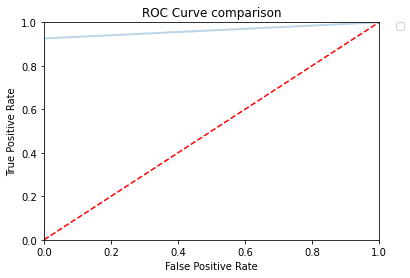

In [27]:
plot_roc_curve(model2, train_X, train_y, test_X)

No handles with labels found to put in legend.


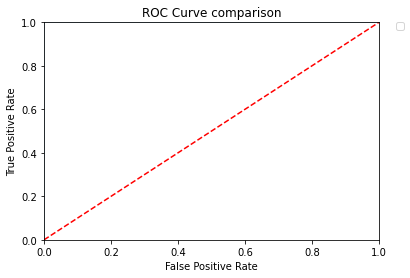

In [28]:
plot_roc_curve(model, train_X, train_y, test_X)

In [29]:
roc_auc_score(test_y, predictions)


1.0

In [30]:
def confusion_matrix(clf, train_X, train_y, test_y,test_X):
		clf = clf.fit(train_X, train_y)
		predictions = clf.predict(test_X)

		from sklearn.metrics import classification_report
		print(classification_report(test_y, predictions))

In [31]:
confusion_matrix(model2, train_X, train_y, test_y,test_X)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        73
           1       1.00      0.93      0.96        54

    accuracy                           0.97       127
   macro avg       0.97      0.96      0.97       127
weighted avg       0.97      0.97      0.97       127



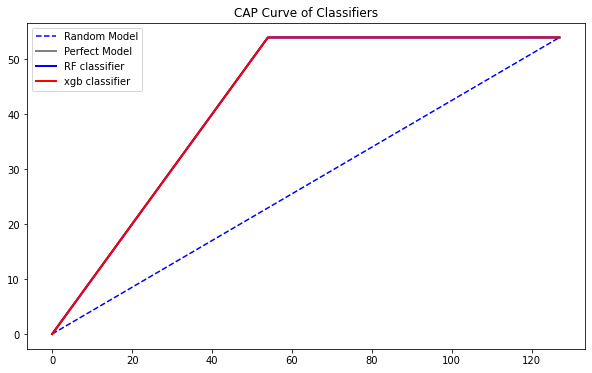

In [32]:
#Visualize the CAP Curve Analysis including all classification models
y_pred_xgb= predictions
y_pred_rf= predictions2
total = len(test_y) 
one_count = np.sum(test_y) 
zero_count = total - one_count 
lm_rf = [y for _, y in sorted(zip(y_pred_rf, test_y), reverse = True)]
lm_xgb = [y for _, y in sorted(zip(y_pred_xgb, test_y), reverse = True)] 

x = np.arange(0, total + 1) 
y_rf = np.append([0], np.cumsum(lm_rf)) 
y_xgb = np.append([0], np.cumsum(lm_xgb)) 
 
plt.figure(figsize = (10, 6)) 
plt.plot([0, total], [0, one_count], c = 'b', linestyle = '--', label = 'Random Model')
plt.plot([0, one_count, total], [0, one_count, one_count], c = 'grey', linewidth = 2, label = 'Perfect Model')
plt.title('CAP Curve of Classifiers')
plt.plot(x, y_rf, c = 'b', label = 'RF classifier', linewidth = 2)
plt.plot(x, y_xgb, c = 'r', label = 'xgb classifier', linewidth = 2)

plt.legend()


In [43]:
#AR


In [82]:
y_preds_proba = model2.predict_proba(test_X)
y_values=test_y



def capcurve(y_values, y_preds_proba):
    num_pos_obs = np.sum(y_values)
    num_count = len(y_values)
    rate_pos_obs = float(num_pos_obs) / float(num_count)
    ideal = pd.DataFrame({'x':[0,rate_pos_obs,1],'y':[0,1,1]})
    xx = np.arange(num_count) / float(num_count - 1)
    
    y_cap = np.c_[y_values,y_preds_proba]
    y_cap_df_s = pd.DataFrame(data=y_cap)
    y_cap_df_s = y_cap_df_s.sort_values([1], ascending=False).reset_index(level = y_cap_df_s.index.names, drop=True)
    
    # print(y_cap_df_s.head(20))
    
    yy = np.cumsum(y_cap_df_s[0]) / float(num_pos_obs)
    yy = np.append([0], yy[0:num_count-1]) #add the first curve point (0,0) : for xx=0 we have yy=0
    
    percent = 0.5
    row_index = int(np.trunc(num_count * percent))
    
    val_y1 = yy[row_index]
    val_y2 = yy[row_index+1]
    if val_y1 == val_y2:
        val = val_y1*1.0
    else:
        val_x1 = xx[row_index]
        val_x2 = xx[row_index+1]
        val = val_y1 + ((val_x2 - percent)/(val_x2 - val_x1))*(val_y2 - val_y1)
    
    sigma_ideal = 1 * xx[num_pos_obs - 1 ] / 2 + (xx[num_count - 1] - xx[num_pos_obs]) * 1
    sigma_model = integrate.simps(yy,xx)
    sigma_random = integrate.simps(xx,xx)
    
    ar_value = (sigma_model - sigma_random) / (sigma_ideal - sigma_random)
    if ar_value>1:
      ar_value=1

    
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    ax.plot(ideal['x'],ideal['y'], color='grey', label='Perfect Model')
    ax.plot(xx,yy, color='red', label='User Model')
    ax.plot(xx,xx, color='blue', label='Random Model')
    ax.plot([percent, percent], [0.0, val], color='green', linestyle='--', linewidth=1)
    ax.plot([0, percent], [val, val], color='green', linestyle='--', linewidth=1, label=str(val*100)+'% of positive obs at '+str(percent*100)+'%')
    
    plt.xlim(0, 1.02)
    plt.ylim(0, 1.25)
    plt.title("CAP Curve - a_r value ="+str(ar_value))
    plt.xlabel('% of the data')
    plt.ylabel('% of positive obs')
    plt.legend()
    return ar_value



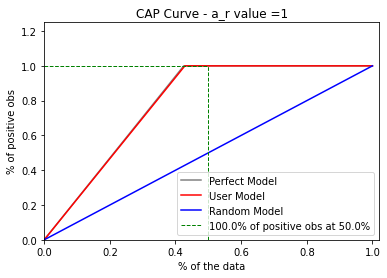

In [83]:
ar_value=capcurve(y_values=test_y, y_preds_proba=y_pred_proba[:,1])

In [85]:
print("ar value=",ar_value )

ar value= 1


In [35]:
#Compute the Kolmogorov-Smirnov statistic on 2 samples
#https://sparky.rice.edu//astr360/kstest.pdf

In [36]:
from scipy import stats

In [37]:
alpha=0.05

In [38]:
# This tests whether 2 samples are drawn from the same distribution.
statistics, pvalue = stats.ks_2samp(predictions, test_y)
print(statistics, pvalue)

0.031496062992125984 0.9999999815425324


In [39]:
if pvalue>alpha:
  print("H0 - the same distribution")
else:
  print("H1 the different one")

H0 - the same distribution


In [40]:
statistics2, pvalue2 =  stats.ks_2samp(predictions2, test_y)

In [41]:
if pvalue2>alpha:
  print("H0 - the same distribution")
else:
  print("H1 the different one")

H0 - the same distribution
